# Data Augmentation
> Recipes for data augmentation

In [ ]:
#hide
from fastai.vision.all import *
from fastai.callback.wandb import *
import wandb

from itertools import chain
from tqdm.notebook import tqdm

from fastai.vision.all import *

def img2rgb(img): return img.convert('RGB')

path = Path('../../data/pokemon')
files = get_image_files(path)

datasets = Datasets(
    files,
    tfms=[[PILImage.create, img2rgb], [parent_label, Categorize]],
    splits=RandomSplitter()(files)
)

## Vision

Setup for this section:

### FastAI transforms
- [Docs](https://docs.fast.ai/vision.augment.html)
- Covers most common transforms (flip, rotate, crop, zoom, warp, lighting, etc.)
- For simplicity, use `aug_transforms`, which is just a wrapper for the `Flip` and `Brightness` transforms:

In [ ]:
aug_transforms()

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

/home/andrew/miniconda/envs/fastpages/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


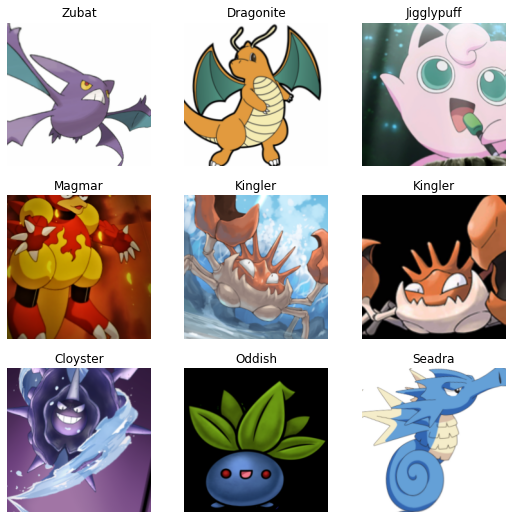

In [ ]:
dataloaders = datasets.dataloaders(
    after_item=[ToTensor, Resize(224)],
    after_batch=[IntToFloatTensor, *aug_transforms()],
    bs=128,
)

dataloaders.show_batch()

### Albumentations Transforms
- [Docs](https://albumentations.ai/docs/api_reference/augmentations/transforms/)
- [Preview transforms](https://albumentations-demo.herokuapp.com/)
- [FastAI tutorial](https://docs.fast.ai/tutorial.albumentations.html)

In [ ]:
import albumentations as A

class ChannelShuffle(DisplayedTransform):
    @delegates(A.ImageOnlyTransform)
    def __init__(self, **kwargs):
        self.aug = A.ChannelShuffle(**kwargs)
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

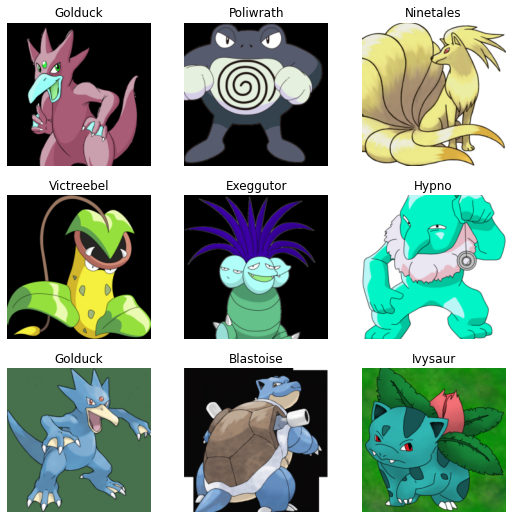

In [ ]:
dataloaders = datasets.dataloaders(
    after_item=[ToTensor, Resize(224), ChannelShuffle(p=0.5)],
    after_batch=[IntToFloatTensor],
    bs=128,
)

dataloaders.show_batch()

### MixUp and variants
- [Yannic Video](https://www.youtube.com/watch?v=a-VQfQqIMrE)
- [MixUp arxiv](https://arxiv.org/abs/1710.09412)
- [CutMix arxiv](https://arxiv.org/abs/1905.04899)
- [FastAI notes](https://docs.fast.ai/callback.mixup.html)

Adapted from: https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
```python
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else:         lam = 1

    batch_size = x.size()[0]
    if use_cuda: index = torch.randperm(batch_size).cuda()
    else:        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
```

FastAI: `Learner(..., cbs=[MixUp(0.4)])`

## Sequence

### Text
#### Text substitution
- https://arxiv.org/pdf/1901.11196.pdf
- "Ice cream is good" --> "Ice cream is great"

#### Embedding substitution
- Replace with k closest embeddings

#### Masking
#### Forwards-to-Backwards translation
- https://arxiv.org/pdf/1904.12848.pdf
- English --> French --> English (or many more languages)

#### Add noise
- Intentional spelling mistakes
- Keyboard-based mistakes
- Shuffle sentence order

### Video
Same as above, and:
#### Change speed
#### 

### Timeseries

## Tabular